50
100
test cost =  0.006214658729732037
MSE between trial and exact solution =  0.0003179194172844291


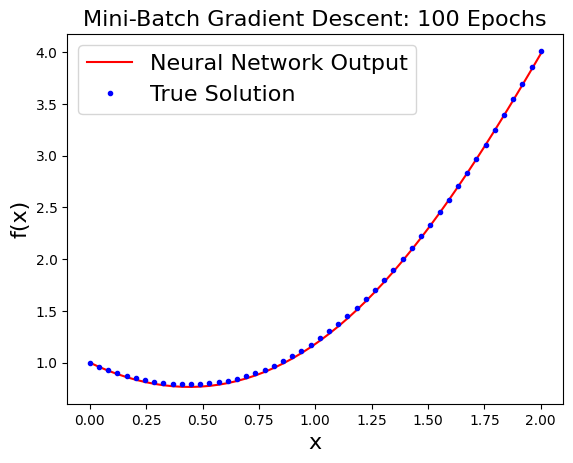

100 epochs total, final cost =  0.008037629
total time elapsed =  9.978682279586792  seconds


Text(0.5, 1.0, 'Mini-Batch Gradient Descent: Training Cost')

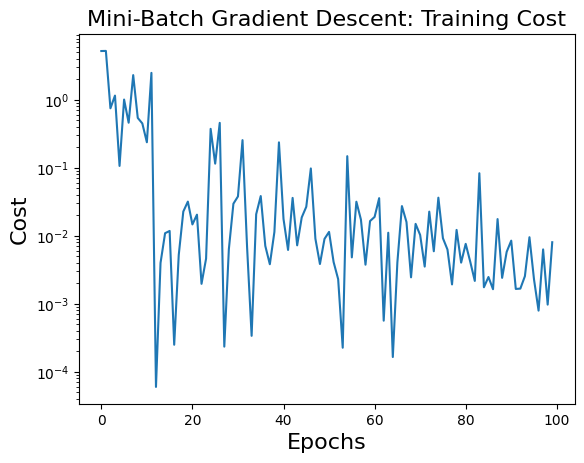

In [ ]:
import torch
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
import time
from torch.autograd import grad

class DataSet(torch.utils.data.Dataset):
    """
    An object which generates the x values for the input node
    """
    def __init__(self, numSamples, xRange):
        """
        Arguments:
        xRange (list of length 2) -- lower and upper limits for input values x
        numSamples (int) -- number of training data samples

        Returns:
        DataSet object with one attributes:
            dataIn (PyTorch tensor of shape (numSamples,1)) -- 'numSamples'
                evenly-spaced data points from xRange[0] to xRange[1]
        """
        self.dataIn  = torch.linspace(xRange[0], xRange[1], numSamples, requires_grad=True).view(-1,1)
        # 'view' method reshapes tensors, in this case into a column vector

    def __len__(self):
        """
        Arguments:
        None

        Returns:
        len(self.dataIn) (int) -- number of training data points
        """
        return len(self.dataIn)

    def __getitem__(self, idx):
        """
        Used by DataLoader object to retrieve training data points

        Arguments:
        idx (int) -- index of data point required

        Returns:
        x (tensor shape (1,1)) -- data point at index 'idx'
        """
        return self.dataIn[idx]

class Fitter(torch.nn.Module):
    """
    The neural network object, with 1 node in the input layer,
    1 node in the output layer, and 1 hidden layer with 'numHiddenNodes' nodes.
    """
    def __init__(self, numHiddenNodes):
        """
        Arguments:
        numHiddenNodes (int) -- number of nodes in hidden layer

        Returns:
        Fitter object (neural network) with two attributes:
        fc1 (fully connected layer) -- linear transformation of hidden layer
        fc2 (fully connected layer) -- linear transformation of outer layer
        """
        super(Fitter, self).__init__()
        self.fc1 = torch.nn.Linear(in_features = 1, out_features = numHiddenNodes)
        self.fc2 = torch.nn.Linear(in_features = numHiddenNodes, out_features = 1)

    def forward(self, x):
        """
        Function which connects inputs to outputs in the neural network.

        Arguments:
        x (PyTorch tensor shape (batchSize,1)) -- input of neural network

        Returns:
        y (PyTorch tensor shape (batchSize,1)) -- output of neural network
        """
        # tanh activation function used on hidden layer
        h = torch.tanh(self.fc1(x))
        # Linear activation function used on outer layer
        y = self.fc2(h)
        return y


def plotNetwork(network, descentType, epoch):
    '''
    Plots the output of the neural network and the analytic solution
    '''
    x    = torch.linspace(xRange[0], xRange[1], 50, requires_grad=True).view(-1,1)
    N    = network.forward(x)
    f_trial = trialFunc(x, N)
    dndx = grad(N, x, torch.ones_like(N), retain_graph=True, create_graph=True)[0]
    df_trial = dTrialFunc(x, N, dndx)
    diff_eq = diffEq(x, f_trial, df_trial)
    cost = lossFn(diff_eq, torch.zeros_like(diff_eq))
    print("test cost = ", cost.item())

    exact = solution(x)
    MSECost = lossFn(f_trial, exact)
    print("MSE between trial and exact solution = ", MSECost.item())
    exact = exact.detach().numpy()
    x = x.detach().numpy()
    N = N.detach().numpy()
    plt.plot(x, trialFunc(x,N), 'r-', label = "Neural Network Output")
    plt.plot(x, exact, 'b.', label = "True Solution")

    plt.xlabel("x", fontsize = 16)
    plt.ylabel("f(x)", fontsize = 16)
    plt.legend(loc = "upper left", fontsize = 16)
    plt.title(descentType + " " + str(epoch) + " Epochs", fontsize = 16)
    plt.show()

def trialFunc1(x, n_out):
    """
    Trial solution to Lagaris problem 1: f(x) = 1 + xN(x)
    Arguments:
        x (tensor of shape (batchSize,1)) -- input of neural network
        n_out (tensor of shape (batchSize,1)) -- output of neural network
    Returns:
        1 + x * n_out (tensor of shape (batchSize,1)) -- trial solution to differential equation
    """
    return 1 + x * n_out

def dTrialFunc1(x, n_out, dndx):
    """
    Derivative of trial solution to Lagaris problem 1: f'(x) = N(x) + xN'(x)
    Arguments:
        x (tensor of shape (batchSize,1)) -- input of neural network
        n_out (tensor of shape (batchSize,1)) -- output of neural network
        dndx (tensor of shape (batchSize,1)) -- derivative of n_out w.r.t. x
    Returns:
        n_out + x * dndx (tensor of shape (batchSize,1)) -- derivative of trial function w.r.t. x
    """
    return n_out + x * dndx

def diffEq1(x, f_trial, df_trial):
    """
    Returns D(x) of differential equation D(x) = 0 from Lagaris problem 1
    Arguments:
        x (tensor of shape (batchSize,1)) -- input of neural network
        f_trial (tensor of shape (batchSize,1)) -- trial solution at x
        df_trial (tensor of shape (batchSize,1)) -- derivative of trial solution at x
    Returns:
        LHS - RHS (tensor of shape (batchSize,1)) -- differential equation evaluated at x"""
    RHS = x**3 + 2*x + (x**2 * ((1+3*x**2) / (1 + x + x**3)))
    LHS = df_trial + ((x + (1+3*(x**2)) / (1 + x + x**3) ) * f_trial)
    return LHS - RHS

def solution1(x):
    """
    Analytic solution to Lagaris problem 1
    Arguments:
        x (tensor of shape (batchSize,1)) -- input of neural network
    Returns:
        y (tensor of shape (batchSize,1)) -- analytic solution of differential equation at x"""
    y =  (torch.exp(-(x**2)/2) / (1 + x + x**3)) + x**2
    return y

def trialFunc2(x, n_out):
    """
    Trial solution to Lagaris problem 2: f(x) = x * N(x)
    Arguments:
        x (tensor of shape (batchSize,1)) -- input of neural network
        n_out (tensor of shape (batchSize,1)) -- output of neural network
    Returns:
        x * n_out (tensor of shape (batchSize,1)) -- trial solution to differential equation
    """
    return x * n_out

def dTrialFunc2(x, n_out, dndx):
    """
    Derivative of trial solution to Lagaris problem 2: f'(x) = N(x) + x * N'(x)
    Arguments:
        x (tensor of shape (batchSize,1)) -- input of neural network
        n_out (tensor of shape (batchSize,1)) -- output of neural network
        dndx (tensor of shape (batchSize,1)) -- derivative of n_out w.r.t. x
    Returns:
        n_out + x * dndx (tensor of shape (batchSize,1)) -- derivative of trial function w.r.t. x
    """
    return n_out + x * dndx

def diffEq2(x, f_trial, df_trial):
    """
    Returns D(x) of differential equation D(x) = 0 from Lagaris problem 2
    Arguments:
        x (tensor of shape (batchSize,1)) -- input of neural network
        f_trial (tensor of shape (batchSize,1)) -- trial solution at x
        df_trial (tensor of shape (batchSize,1)) -- derivative of trial solution at x
    Returns:
        LHS - RHS (tensor of shape (batchSize,1)) -- differential equation evaluated at x"""
    RHS = df_trial + (1/5)*f_trial
    LHS = torch.exp(-x/5) * torch.cos(x)
    return LHS - RHS

def solution2(x):
    """
    Analytic solution to Lagaris problem 1
    Arguments:
        x (tensor of shape (batchSize,1)) -- input of neural network
    Returns:
        y (tensor of shape (batchSize,1)) -- analytic solution of differential equation at x"""
    y = torch.exp(-x/5) * torch.sin(x)
    return y


descentType = "Mini-Batch Gradient Descent:"

def train(network, loader, lossFn, optimiser, numEpochs):
    """
    A function to train a neural network to solve a
    first-order ODE with Dirichlet boundary conditions.

    Arguments:
    network (Module) -- the neural network
    loader (DataLoader) -- generates batches from the training dataset
    lossFn (Loss Function) -- network's loss function
    optimiser (Optimiser) -- carries out parameter optimisation
    numEpochs (int) -- number of training epochs

    Returns:
    costList (list of length 'numEpochs') -- cost values of all epochs
    """
    cost_list=[]
    network.train(True) # set module in training mode
    for epoch in range(numEpochs):
        for batch in loader:
            n_out = network.forward(batch) # network output

            # Get derivative of the network output w.r.t. the input values:
            dndx = grad(n_out, batch, torch.ones_like(n_out), retain_graph=True)[0]
            # torch.ones_like(x) creates a tensor the same shape as x, filled with 1's

            # Get value of trial solution f(x)
            f_trial = trialFunc(batch, n_out)
            # Get df / dx
            df_trial = dTrialFunc(batch, n_out, dndx)
            # Get LHS of differential equation D(x) = 0
            diff_eq = diffEq(batch, f_trial, df_trial)

            cost = lossFn(diff_eq, torch.zeros_like(diff_eq)) # calculate cost
            # torch.zeros_like(x) creates a tensor the same shape as x, filled with 0's
            cost.backward() # perform backpropagation
            optimiser.step() # perform parameter optimisation
            optimiser.zero_grad() # reset gradients to zero

        cost_list.append(cost.detach().numpy())# store cost of each epoch
    network.train(False) # set module out of training mode
    return cost_list

try: # load saved network if possible
    checkpoint = torch.load('problem1.pth')
    # checkpoint = torch.load('problem2.pth')
    network    = checkpoint['network']
except: # create new network
    network    = Fitter(numHiddenNodes=10)
    checkpoint = {'network': network}
    torch.save(checkpoint, 'problem1.pth')
    # torch.save(checkpoint, 'problem2.pth')
xRange       = [0, 2]
numSamples   = 20
batchSize    = 1
paramUpdates = 20000
train_set    = DataSet(numSamples, xRange)
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batchSize, shuffle=True)
lossFn       = torch.nn.MSELoss()
optimiser    = torch.optim.SGD(network.parameters(), lr=1e-3)

solution = solution1
trialFunc = trialFunc1
dTrialFunc = dTrialFunc1
diffEq = diffEq1

# solution = solution2
# trialFunc = trialFunc2
# dTrialFunc = dTrialFunc2
# diffEq = diffEq2

costList = []
epoch = 0
numEpochs = 50
# totalEpochs = int((batchSize/numSamples) * paramUpdates)
totalEpochs = 100
start = time.time()
while epoch < totalEpochs:
    costList.extend(train(network, train_loader, lossFn, optimiser, numEpochs))
    epoch += numEpochs
    print(epoch)
end = time.time()


plotNetwork(network, descentType, epoch)
print(epoch, "epochs total, final cost = ", costList[-1])
print("total time elapsed = ", end - start, " seconds")

plt.semilogy(costList)
plt.xlabel("Epochs",fontsize = 16)
plt.ylabel("Cost",fontsize = 16)
plt.title(descentType + " Training Cost",fontsize = 16)


